In [1]:
# installing Libraries
!pip install transformers
!pip install -U datasets
!pip install soundfile
!pip install librosa
!pip install gradio
!pip install jiwer

In [2]:
# For handling and processing audio
import librosa
import librosa.display
import torchaudio
import torchaudio.transforms as transforms
import torchaudio.transforms as T


# For data manipulation
import numpy as np
import pandas as pd
import os
import glob
import re



# For deep learning model development
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.models as models
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Audio


# For evaluation and metrics
from jiwer import wer, cer  # Word Error Rate and Character Error Rate

# Visualization
import matplotlib.pyplot as plt

# Miscellaneous utilities
from tqdm import tqdm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


In [3]:
from datasets import load_dataset, interleave_datasets

# Load individual LibriSpeech subsets
train_clean_100 = load_dataset(
    "librispeech_asr",
    split="train.clean.100",
    streaming=True,
    trust_remote_code=True
)

train_clean_360 = load_dataset(
    "librispeech_asr",
    split="train.clean.360",
    streaming=True,
    trust_remote_code=True
)

train_other_500 = load_dataset(
    "librispeech_asr",
    split="train.other.500",
    streaming=True,
    trust_remote_code=True
)

# Combine all subsets into one dataset
dataset = interleave_datasets([train_clean_100, train_clean_360, train_other_500])

# Inspect a few samples from the combined dataset
for sample in dataset.take(3):  # Take 3 samples to verify
    print(f"Audio Path: {sample['audio']['path']}")
    print(f"Text: {sample['text']}")
    print(f"Sampling Rate: {sample['audio']['sampling_rate']}")
    print("----")
    break

Audio Path: 374-180298-0000.flac
Text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Sampling Rate: 16000
----


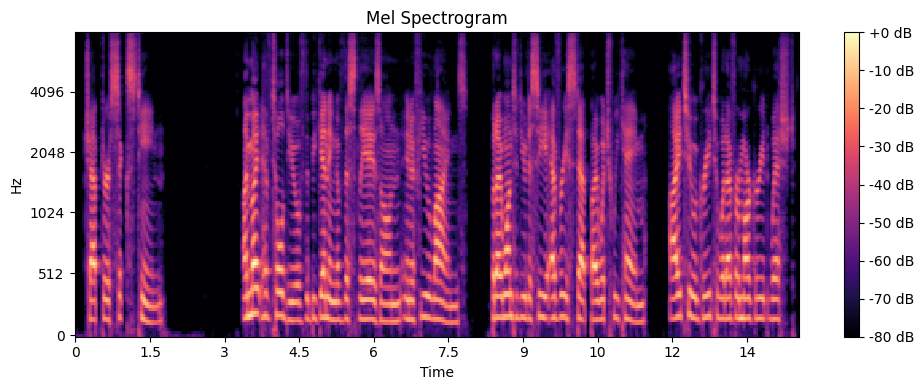

In [4]:
# Cast the audio feature to decode it automatically
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Updated preprocessing function
def preprocess_audio(audio):
    # Get the waveform and sampling rate directly
    waveform = np.array(audio["array"])
    sample_rate = audio["sampling_rate"]

    # Generate Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db, sample_rate

# Example usage
for sample in dataset.take(1):
    audio = sample['audio']  # Decoded audio
    mel_spectrogram, sample_rate = preprocess_audio(audio)
    
    # Display Mel Spectrogram
    import librosa.display
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    break

In [5]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphanumeric characters (except spaces and apostrophes)
    text = re.sub(r"[^a-z' ]", "", text)
    
    return text

# Example usage
for sample in dataset.take(1):
    raw_text = sample['text']
    processed_text = preprocess_text(raw_text)
    print(f"Original Text: {raw_text}")
    print(f"Processed Text: {processed_text}")
    break

Original Text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Processed Text: chapter sixteen i might have told you of the beginning of this liaison in a few lines but i wanted you to see every step by which we came i to agree to whatever marguerite wished


In [6]:
# Character-level tokenization
def tokenize_text(text):
    # Convert text to a list of characters
    return list(text)

# Example usage
for sample in dataset.take(1):
    processed_text = preprocess_text(sample['text'])
    tokens = tokenize_text(processed_text)
    print(f"Processed Text: {processed_text}")
    print(f"Tokens: {tokens}")
    break


Processed Text: chapter sixteen i might have told you of the beginning of this liaison in a few lines but i wanted you to see every step by which we came i to agree to whatever marguerite wished
Tokens: ['c', 'h', 'a', 'p', 't', 'e', 'r', ' ', 's', 'i', 'x', 't', 'e', 'e', 'n', ' ', 'i', ' ', 'm', 'i', 'g', 'h', 't', ' ', 'h', 'a', 'v', 'e', ' ', 't', 'o', 'l', 'd', ' ', 'y', 'o', 'u', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'b', 'e', 'g', 'i', 'n', 'n', 'i', 'n', 'g', ' ', 'o', 'f', ' ', 't', 'h', 'i', 's', ' ', 'l', 'i', 'a', 'i', 's', 'o', 'n', ' ', 'i', 'n', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'l', 'i', 'n', 'e', 's', ' ', 'b', 'u', 't', ' ', 'i', ' ', 'w', 'a', 'n', 't', 'e', 'd', ' ', 'y', 'o', 'u', ' ', 't', 'o', ' ', 's', 'e', 'e', ' ', 'e', 'v', 'e', 'r', 'y', ' ', 's', 't', 'e', 'p', ' ', 'b', 'y', ' ', 'w', 'h', 'i', 'c', 'h', ' ', 'w', 'e', ' ', 'c', 'a', 'm', 'e', ' ', 'i', ' ', 't', 'o', ' ', 'a', 'g', 'r', 'e', 'e', ' ', 't', 'o', ' ', 'w', 'h', 'a', 't', 'e', 'v', 'e', '

In [7]:
# Combined preprocessing function
def preprocess_sample(sample):
    # Process audio
    mel_spectrogram, _ = preprocess_audio(sample['audio'])
    
    # Process text
    transcript = preprocess_text(sample['text'])
    tokens = tokenize_text(transcript)
    
    return mel_spectrogram, tokens

# Example usage
for sample in dataset.take(1):
    mel_spectrogram, tokens = preprocess_sample(sample)
    print(f"Mel Spectrogram Shape: {mel_spectrogram.shape}")
    print(f"Tokens: {tokens}")
    break


Mel Spectrogram Shape: (128, 455)
Tokens: ['c', 'h', 'a', 'p', 't', 'e', 'r', ' ', 's', 'i', 'x', 't', 'e', 'e', 'n', ' ', 'i', ' ', 'm', 'i', 'g', 'h', 't', ' ', 'h', 'a', 'v', 'e', ' ', 't', 'o', 'l', 'd', ' ', 'y', 'o', 'u', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'b', 'e', 'g', 'i', 'n', 'n', 'i', 'n', 'g', ' ', 'o', 'f', ' ', 't', 'h', 'i', 's', ' ', 'l', 'i', 'a', 'i', 's', 'o', 'n', ' ', 'i', 'n', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'l', 'i', 'n', 'e', 's', ' ', 'b', 'u', 't', ' ', 'i', ' ', 'w', 'a', 'n', 't', 'e', 'd', ' ', 'y', 'o', 'u', ' ', 't', 'o', ' ', 's', 'e', 'e', ' ', 'e', 'v', 'e', 'r', 'y', ' ', 's', 't', 'e', 'p', ' ', 'b', 'y', ' ', 'w', 'h', 'i', 'c', 'h', ' ', 'w', 'e', ' ', 'c', 'a', 'm', 'e', ' ', 'i', ' ', 't', 'o', ' ', 'a', 'g', 'r', 'e', 'e', ' ', 't', 'o', ' ', 'w', 'h', 'a', 't', 'e', 'v', 'e', 'r', ' ', 'm', 'a', 'r', 'g', 'u', 'e', 'r', 'i', 't', 'e', ' ', 'w', 'i', 's', 'h', 'e', 'd']


In [8]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, num_classes, input_features=128, hidden_size=256, num_layers=3):
        super(SpeechRecognitionModel, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Single-channel input (Mel Spectrogram)
        self.pool = nn.MaxPool2d(2, 2)  # Down-sampling
        
        # RNN sequence model
        self.rnn = nn.LSTM(input_size=input_features//2,  # After pooling
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           bidirectional=True)
        
        # Fully connected output
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bidirectional doubles hidden size
    
    def forward(self, x):
        # Input shape: (batch_size, 1, features, time)
        x = self.cnn(x)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 32, features/2, time/2)
        
        # Reshape for RNN input: (batch_size, time, features)
        x = x.squeeze(1).permute(0, 2, 1)  # Remove channel dimension, swap time and features
        
        # RNN
        x, _ = self.rnn(x)  # (batch_size, time, hidden_size * 2)
        
        # Fully connected output
        x = self.fc(x)  # (batch_size, time, num_classes)
        
        return x

In [9]:
# Define vocabulary (a-z and space)
vocab = ["<blank>", "a", "b", "c", ..., "z", " "]
num_classes = len(vocab)

# Create the model
model = SpeechRecognitionModel(num_classes=num_classes)
print(model)


SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)


In [10]:
import torch
import torch.nn as nn

# Define the CTC Loss
ctc_loss = nn.CTCLoss(blank=0)  # Blank token index is 0

# Parameters
batch_size = 16
time_steps = 50  # Number of timesteps
num_classes = 30  # Vocabulary size (including blank token)

# Simulated log probabilities (logits after applying log_softmax)
log_probs = torch.randn(batch_size, time_steps, num_classes).log_softmax(2)

# Input lengths: All inputs have `time_steps` length
input_lengths = torch.full(size=(batch_size,), fill_value=time_steps, dtype=torch.long)

# Target lengths: Random lengths less than or equal to `time_steps`
target_lengths = torch.randint(10, time_steps // 2, (batch_size,), dtype=torch.long)

# Generate target sequences with the correct size (sum of target_lengths)
targets = torch.randint(1, num_classes, (target_lengths.sum().item(),), dtype=torch.long)

# Transpose log_probs to (time_steps, batch_size, num_classes)
log_probs = log_probs.permute(1, 0, 2)

# Debug: Print input shapes and values
print(f"log_probs shape: {log_probs.shape}")  # (time_steps, batch_size, num_classes)
print(f"targets shape: {targets.shape}")      # (sum of target_lengths)
print(f"input_lengths shape: {input_lengths.shape}")  # (batch_size)
print(f"input_lengths: {input_lengths}")             # Values should be <= time_steps
print(f"target_lengths shape: {target_lengths.shape}")  # (batch_size)
print(f"target_lengths: {target_lengths}")            # Values should be <= max_target_length

# Compute the CTC Loss
loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
print("CTC Loss:", loss.item())


log_probs shape: torch.Size([50, 16, 30])
targets shape: torch.Size([289])
input_lengths shape: torch.Size([16])
input_lengths: tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])
target_lengths shape: torch.Size([16])
target_lengths: tensor([24, 13, 17, 10, 23, 19, 17, 17, 22, 10, 14, 23, 18, 23, 24, 15])
CTC Loss: 8.156824111938477


In [11]:
# Define a simple model for demonstration (replace with your model)
class SimpleSpeechRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSpeechRecognitionModel, self).__init__()
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256 * 2, num_classes)  # Bidirectional doubles hidden size

    def forward(self, x):
        # x: (batch_size, time_steps, features)
        x, _ = self.lstm(x)
        x = self.fc(x)  # (batch_size, time_steps, num_classes)
        return x.log_softmax(2)

# Initialize the model, optimizer, and loss function
model = SimpleSpeechRecognitionModel(num_classes=30).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    
    # Simulate a batch of inputs (features: batch_size x time_steps x features)
    inputs = torch.randn(batch_size, time_steps, 128).to("cuda")  # Example input
    input_lengths = torch.full(size=(batch_size,), fill_value=time_steps, dtype=torch.long).to("cuda")
    target_lengths = torch.randint(10, time_steps // 2, (batch_size,), dtype=torch.long).to("cuda")
    targets = torch.randint(1, 30, (target_lengths.sum().item(),), dtype=torch.long).to("cuda")
    
    # Forward pass
    log_probs = model(inputs).permute(1, 0, 2)  # (time_steps, batch_size, num_classes)

    # Compute the loss
    loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 7.9274
Epoch [2/10], Loss: 9.0248
Epoch [3/10], Loss: 8.1723
Epoch [4/10], Loss: 7.1347
Epoch [5/10], Loss: 6.5270
Epoch [6/10], Loss: 6.5419
Epoch [7/10], Loss: 4.8454
Epoch [8/10], Loss: 3.6146
Epoch [9/10], Loss: 4.4580
Epoch [10/10], Loss: 4.5843


In [12]:
from jiwer import wer, cer

# Simulate predictions and references (example data)
predicted_texts = ["hello world", "speech recognition is cool"]
reference_texts = ["hello world", "speech recognition is amazing"]

# Calculate metrics
wer_score = wer(reference_texts, predicted_texts)
cer_score = cer(reference_texts, predicted_texts)

print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Character Error Rate (CER): {cer_score:.4f}")


Word Error Rate (WER): 0.1667
Character Error Rate (CER): 0.1750


In [72]:
checkpoint = torch.load("speech_to_text_model.pth")
print(checkpoint.keys())


odict_keys(['conv.0.weight', 'conv.0.bias', 'conv.1.weight', 'conv.1.bias', 'conv.1.running_mean', 'conv.1.running_var', 'conv.1.num_batches_tracked', 'conv.3.weight', 'conv.3.bias', 'conv.4.weight', 'conv.4.bias', 'conv.4.running_mean', 'conv.4.running_var', 'conv.4.num_batches_tracked', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l1_reverse', 'lstm.weight_hh_l1_reverse', 'lstm.bias_ih_l1_reverse', 'lstm.bias_hh_l1_reverse', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l2_reverse', 'lstm.weight_hh_l2_reverse', 'lstm.bias_ih_l2_reverse', 'lstm.bias_hh_l2_reverse', 'fc.weight', 'fc.bias'])


In [73]:
torch.save(model, "model_complete.pth")


In [74]:
model = torch.load("model_complete.pth")
model.eval()


SimpleSpeechRecognitionModel(
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=30, bias=True)
)

In [75]:
# Save the trained model
torch.save(model.state_dict(), "speech_to_text_model.pth")
print("Model saved as 'speech_to_text_model.pth'")


Model saved as 'speech_to_text_model.pth'


In [77]:
import gradio as gr

def speech_to_text(audio_file_path):
    """
    Convert speech to text using the trained model.
    
    Args:
        audio_file_path (str): Path to the audio file.

    Returns:
        str: Transcription of the audio.
    """
    # Preprocess audio file
    audio, sr = librosa.load(audio_file_path, sr=16000)
    mel_spectrogram = compute_mel_spectrogram(torch.tensor(audio), sample_rate=sr).unsqueeze(0)

    # Predict using the model
    with torch.no_grad():
        logits = model(mel_spectrogram)
        predicted_text = decode_predictions(logits, vocab)
    
    return predicted_text

# Define the Gradio interface
interface = gr.Interface(
    fn=speech_to_text,
    inputs=gr.Audio(type="filepath"),  # Automatically captures audio from the microphone
    outputs="text",
    title="Speech-to-Text Converter",
    description="Speak into the microphone, and the model will transcribe your speech into text."
)

# Launch the Gradio app
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://2036b2dfbde77417e9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
